# EX17) Demo of affinity propagation clustering algorithm
- 선호도 전파 클러스터링 알고리즘(?)
- https://jaehc.github.io/ml/affinity-propagation/

In [12]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import make_blobs

In [13]:
# Generate sample data

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

In [14]:
# Compute Affinity Propagation

af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print(f'Estimated number of clusters: {int(n_clusters_)}')
print(f'Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}')
print(f'Completeness: {metrics.completeness_score(labels_true, labels):.3f}')
print(f'V-measure: {metrics.v_measure_score(labels_true, labels):.3f}')
print(f'Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}')
print(f'Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}')
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, labels, metric="sqeuclidean"):.3f}')

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


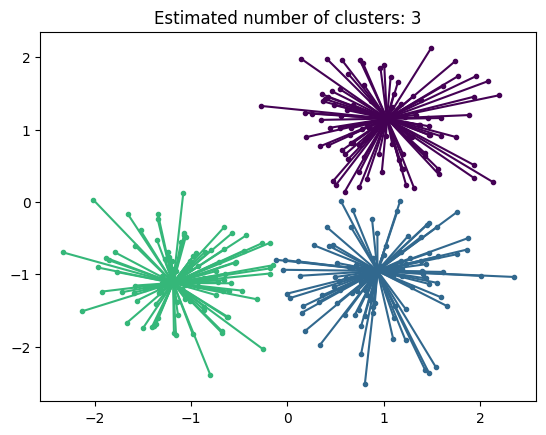

In [18]:
# Plotting

import matplotlib.pyplot as plt

plt.close('all')
plt.figure(1)
plt.clf()

colors = plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 4)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.scatter(
        X[class_members, 0], X[class_members, 1], color=col['color'], marker='.'
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for x in X[class_members]:
        plt.plot(
            [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col['color']
        )

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# EX18) Demonstration of k-means assumptions

In [19]:
# Data generation

import numpy as np
from sklearn.datasets import make_blobs

n_samples = 1_500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
X_filtered = np.vstack(
    (X[y==0][:500], X[y==1][:100], X[y==2][:10])
)
y_filtered = [0]*500 + [1]*100 + [2]*10

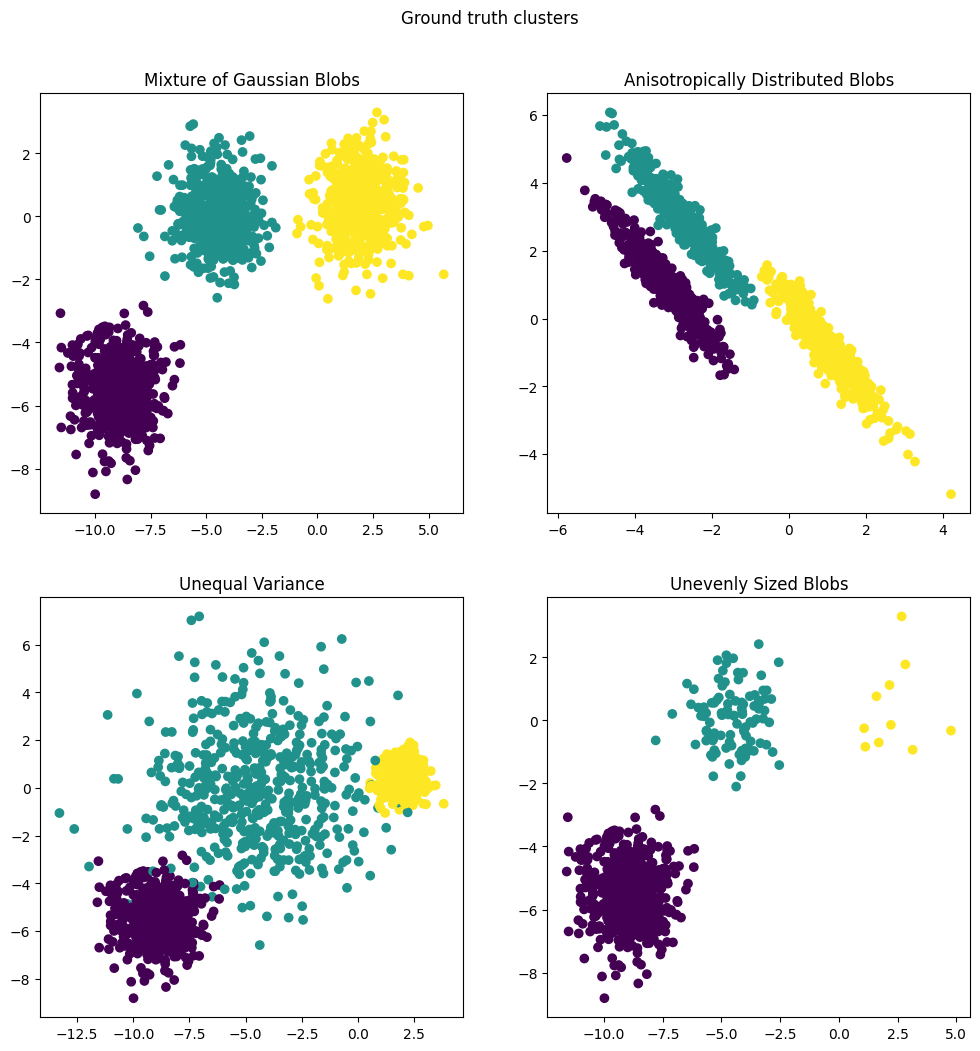

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
titles = ['Mixture of Gaussian Blobs',
          'Anisotropically Distributed Blobs',
          'Unequal Variance',
          'Unevenly Sized Blobs']
data_pairs = [(X, y),
              (X_aniso, y),
              (X_varied, y_varied),
              (X_filtered, y_filtered)]

idx = 0
for i in range(2):
    for j in range(2):
        axs[i, j].scatter(data_pairs[idx][0][:, 0], data_pairs[idx][0][:, 1], c=data_pairs[idx][1])
        axs[i, j].set_title(titles[idx])
        idx += 1

plt.suptitle('Ground truth clusters').set_y(0.95)
plt.show()

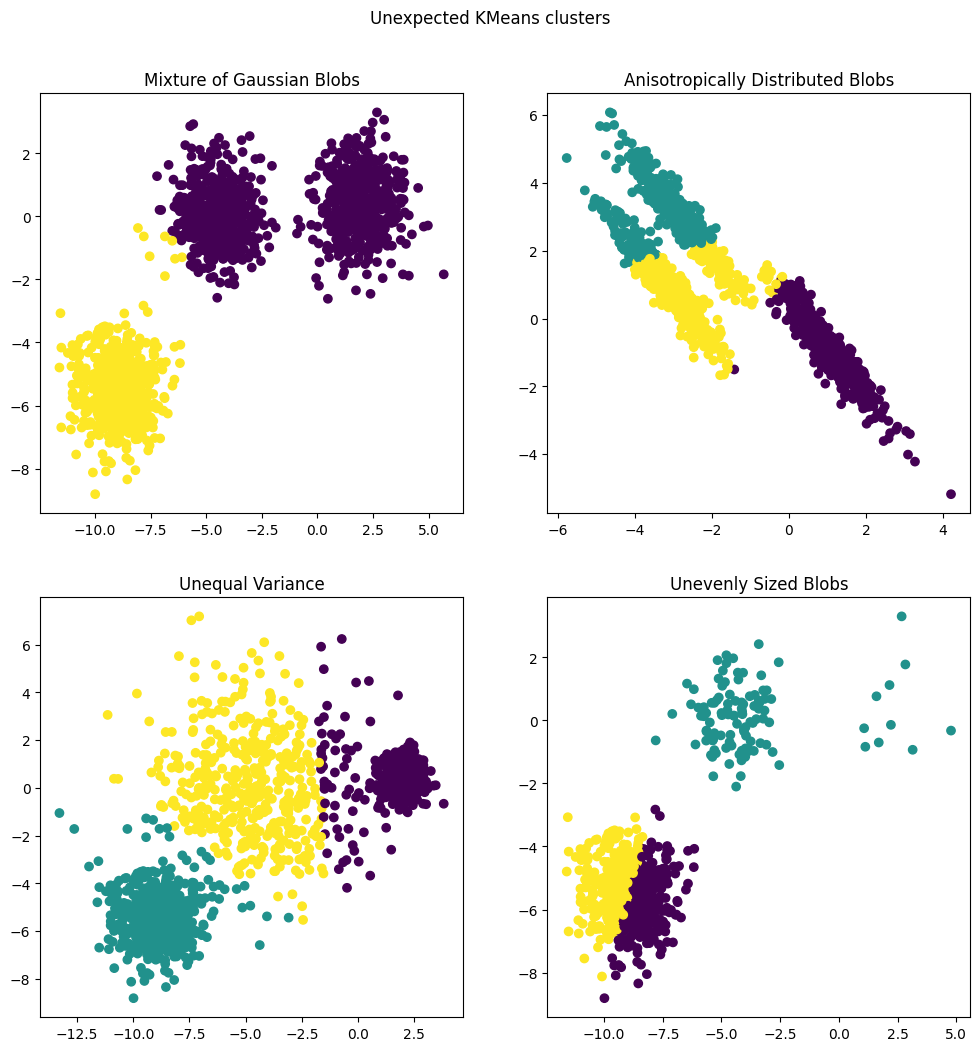

In [24]:
# Fit models and plot results

from sklearn.cluster import KMeans

common_params = {
    'n_init' : 'auto',
    'random_state' : random_state
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

idx = 0
for i in range(2):
    for j in range(2):
        n_clusters = 2 if idx == 0 else 3
        y_pred = KMeans(n_clusters=n_clusters, **common_params).fit_predict(data_pairs[idx][0])
        axs[i, j].scatter(data_pairs[idx][0][:, 0], data_pairs[idx][0][:, 1], c=y_pred)
        axs[i, j].set_title(titles[idx])
        idx += 1

plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.show()

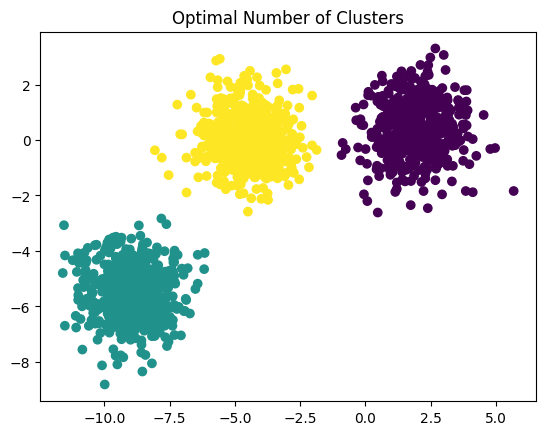

In [25]:
y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title('Optimal Number of Clusters')
plt.show()

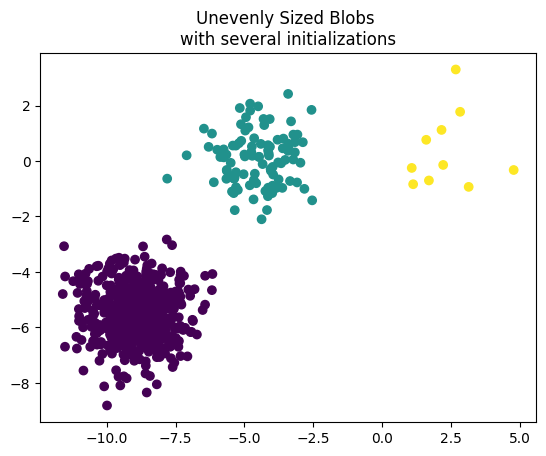

In [26]:
y_pred = KMeans(n_clusters=3, n_init=10, random_state=random_state).fit_predict(
    X_filtered
)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title('Unevenly Sized Blobs \nwith several initializations')
plt.show()

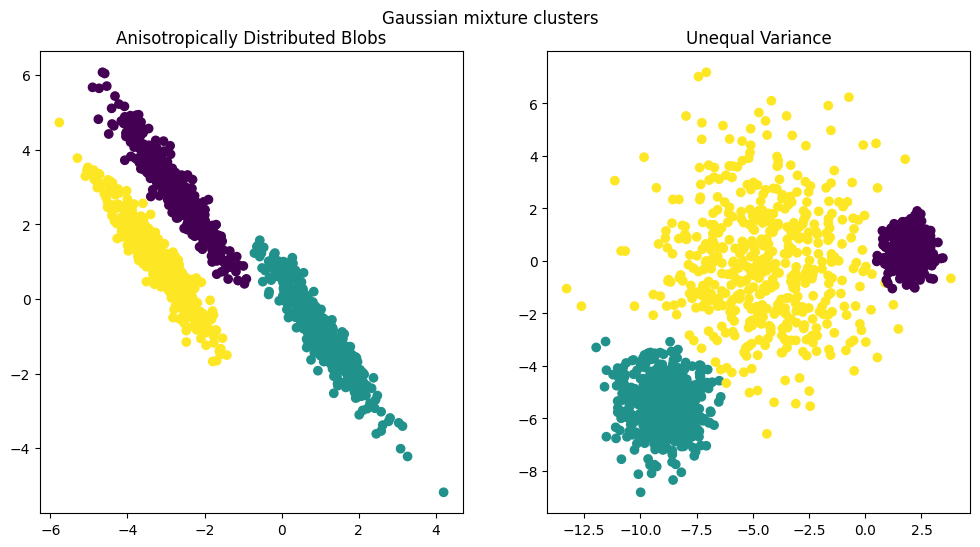

In [27]:
from sklearn.mixture import GaussianMixture

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

y_pred = GaussianMixture(n_components=3).fit_predict(X_aniso)
ax1.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
ax1.set_title('Anisotropically Distributed Blobs')

y_pred = GaussianMixture(n_components=3).fit_predict(X_varied)
ax2.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
ax2.set_title('Unequal Variance')

plt.suptitle('Gaussian mixture clusters').set_y(0.95)
plt.show()

# EX19) Empirical evaluation of the impact of k-means initialization
- k-means Initialization 성능 평가

In [32]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import check_random_state, shuffle

random_state = np.random.RandomState(0)

n_runs = 5
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size**2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1])
    )

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


Text(0.5, 1.0, 'Mean inertia for various k-means init across 5 runs')

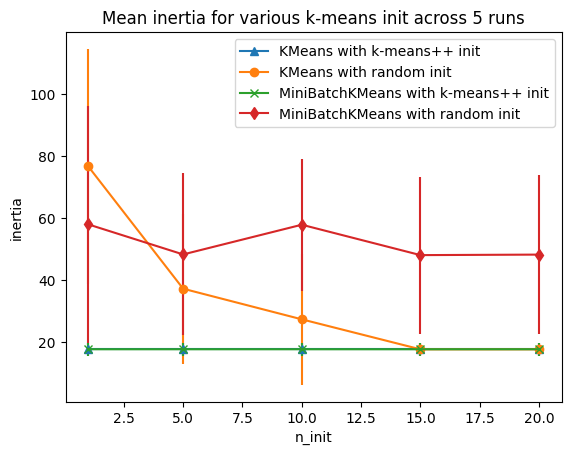

In [33]:
plt.figure()
plots = []
legends = []

cases = [
    (KMeans, 'k-means++', {}, '^-'),
    (KMeans, 'random', {}, 'o-'),
    (MiniBatchKMeans, 'k-means++', {'max_no_improvement': 3}, 'x-'),
    (MiniBatchKMeans, 'random', {'max_no_improvement': 3, 'init_size': 500}, 'd-'),
]

for factory, init, params, format in cases:
    print('Evaluation of %s with %s init' % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init,
                **params,
            ).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(
        n_init_range, inertia.mean(axis=1), inertia.std(axis=1), fmt=format
    )
    plots.append(p[0])
    legends.append('%s with %s init' % (factory.__name__, init))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(plots, legends)
plt.title('Mean inertia for various k-means init across %d runs' % n_runs)

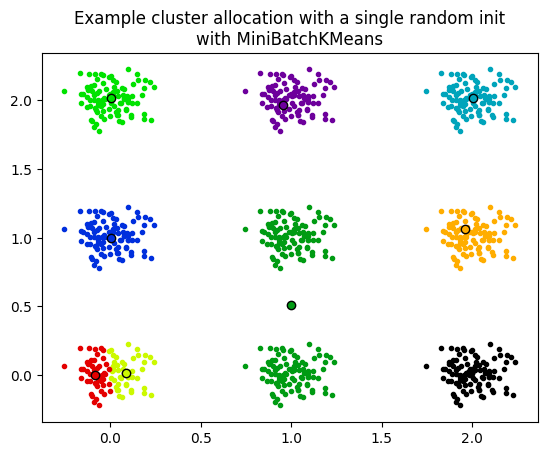

In [34]:
X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(
    n_clusters=n_clusters, init='random', n_init=1, random_state=random_state
).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], '.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        'o',
        markerfacecolor=color,
        markeredgecolor='k',
        markersize=6,
    )
    plt.title(
        'Example cluster allocation with a single random init\nwith MiniBatchKMeans'
    )

plt.show()

# EX20) Feature agglomeration
- 유사한 형상으로 병합되는 방법

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets
from sklearn.feature_extraction.image import grid_to_graph

digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
connectivity = grid_to_graph(*images[0].shape)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32)

agglo.fit(X)
X_reduced = agglo.transform(X)

X_restored = agglo.inverse_transform(X_reduced)
images_restored = np.reshape(X_restored, images.shape)

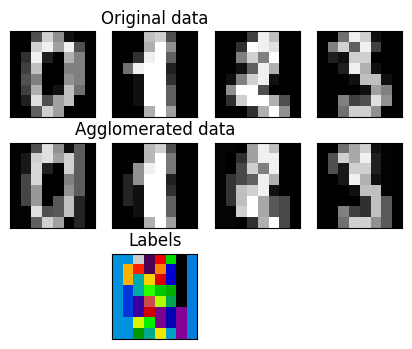

In [40]:
plt.figure(1, figsize=(4, 3.5))
plt.clf()
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    if i == 1:
        plt.title('Original data')
    plt.subplot(3, 4, 4 + i + 1)
    plt.imshow(images_restored[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    if i == 1:
        plt.title('Agglomerated data')
    plt.xticks(())
    plt.yticks(())

plt.subplot(3, 4, 10)
plt.imshow(
    np.reshape(agglo.labels_, images[0].shape),
    interpolation='nearest',
    cmap=plt.cm.nipy_spectral,
)
plt.xticks(())
plt.yticks(())
plt.title('Labels')
plt.show()